In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
from sklearn import preprocessing
from skimage import exposure
from os import listdir
from scipy import misc
import csv
from math import *
import random
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_DIR = './train/'

f_list = []
label_list = []
i = 0
there_is_file = True
for fname in listdir(TRAIN_DIR):
    if 'dog' in fname:
        f_list.append(TRAIN_DIR + fname)
        label_list.append(1)
    if 'cat' in fname:
        f_list.append(TRAIN_DIR + fname)
        label_list.append(0)

print ('files, labels', len(f_list), len(label_list))
print ('dogs, cats', label_list.count(0), label_list.count(1))

files, labels 25000 25000
dogs, cats 12500 12500


In [3]:
x_train, x_test, y_train, y_test = train_test_split(f_list, label_list, test_size = 0.33, random_state = 44)
print ('files, labels', len(x_train), len(y_train))
print ('dogs, cats', y_train.count(0), y_train.count(1))

files, labels 16750 16750
dogs, cats 8393 8357


In [2]:
def get_img(fname):
    img = misc.imread(fname)
    img = misc.imresize(img, (32, 32))
    img = exposure.equalize_hist(img)
    return img

def generator(x_set, y_set, batch_size = 100):
    binary_labels = [[1,0], [0,1]]
    while True:
        x_set, y_set = shuffle(x_set, y_set)
        x = []
        y = []
        for i in range(batch_size):
            x.append(get_img(x_set[i]))
            y.append(binary_labels[y_set[i]])
        
        yield np.float32(x), np.array(y)
            

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


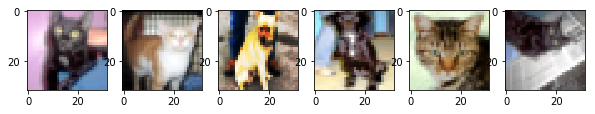

In [5]:
gen = generator(x_train, y_train, batch_size = 6)
x, y = next(gen)

plt.figure(figsize=(10,10))
for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    plt.imshow(x[i])
print (y)

In [6]:
model = Sequential()

model.add(Convolution2D(32,3,3, input_shape = (32, 32, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Convolution2D(128,3,3))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1000))
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(2))



In [9]:
gen = generator(x_train, y_train, batch_size = 300)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch=8000, nb_epoch=3)


Epoch 1/3


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


8100/8000 [==============================] - 41s - loss: 0.3413 - acc: 0.5079     

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/3
8100/8000 [==============================] - 40s - loss: 0.2451 - acc: 0.5559     

In [13]:
history = model.fit_generator(gen, samples_per_epoch=8000, nb_epoch=5)


Epoch 1/5


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


8100/8000 [==============================] - 41s - loss: 0.2090 - acc: 0.6785     

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
8100/8000 [==============================] - 41s - loss: 0.2090 - acc: 0.6705     

In [14]:
test_gen = generator(x_test, y_test, batch_size = 100)
Xt, Yt = next(test_gen)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


In [15]:
preds = model.predict(Xt)
pred_labels = np.argmax(preds, axis=1)

truth = np.argmax(Yt, axis=1)
match_ratio = sum(pred_labels == truth)

print ("Accuracy on test set", match_ratio)

Accuracy on test set 63


In [132]:
#model.save('my_model_64percent.h5')

In [18]:
# loading the test data
TEST_DIR = './test/'
test_set = []

fname_list = listdir(TEST_DIR)

def fname_key(x):
    i = x.split('.')[0]
    return int(i)

for fname in sorted(fname_list, key=fname_key):
    test_set.append(get_img(TEST_DIR + fname))
test_set = np.float32(test_set)
print(test_set.shape)
                    


/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


(12500, 32, 32, 3)


In [19]:
import pickle
print (test_set.shape)
#pickle.dump(test_set, open('evaluation_data.p', 'wb'))

(12500, 32, 32, 3)


In [22]:
# loading the model and the eval data
with open('evaluation_data.p', 'rb') as handle:
    test_set = pickle.load(handle)
m = load_model('my_model.h5')
test_preds = m.predict(test_set)
print (test_preds.shape)

(12500, 2)


In [23]:
f = open('my_preds2.csv', 'w')
print ('id,label', file=f)
for i, row in enumerate(test_preds):
    print ('{},{}'.format(i+1,row[1]), file=f)
f.close()